In [1]:
%matplotlib inline
import struct
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import entropy
import scipy.misc as smp
hamming = np.array([0.54-0.46*np.cos(2*np.pi*i/511.0) for i in range(512)])

In [2]:
def compute_acoustic_indices_batch(w, total_length, t, fbs=256, fs=48000):
    """
    w : wav file
    total_length : total length of the recording (in seconds)
    t: time span for three indices (in seconds)
    fbs : number of frequency bins
    fs : sample rate of the wav file
    """
    freqs = np.linspace(0, fs/2, fbs)
    N = t*fs//(2*fbs) # number of cells in each time span
    AMP_THR = 1.2589 # amplitude that corresponds to 2 dB
    aci_matrix = []
    h_t_matrix = []
    cvr_matrix = []
    fft_matrix = []
    aci_previous = np.zeros(fbs)
    for j in range(total_length//t): # for each time span
        amps = np.array([np.abs(np.fft.rfft(w[j*fs+i*2*fbs:j*fs+(i+1)*2*fbs]*hamming, 2*fbs))[:fbs] for i in range(N)]) # fft the corresponding segment
        aci = (np.abs(amps[0]-aci_previous)+np.sum(np.abs(np.diff(amps,axis=0)),axis=0))/np.sum(amps,axis=0) # aci vector
        aci_previous = amps[-1]
#         aci_avg = np.average(aci[14:]) # remove low freqs, this is aci_index (not used at the moment)
        aci_matrix.append(aci)
        prob_masses = [amps[:,i]**2/np.sum(amps[:,i]**2) for i in range(fbs)] # entropy for each freq bin
        entropies = [entropy(e)/np.log(N) for e in prob_masses] # H[t] vector
#         e = np.abs(np.fft.rfft(w))**2
#         h_t = entropy(e/np.sum(e))/np.log2(N) # entropy of the signal
        h_t_matrix.append(entropies)
    
        amps_mean = np.average(amps,axis=0)
        amps_std = np.std(amps,axis=0)
        fft_matrix.append(amps_mean*N)
        noise = amps_mean+0.1*amps_std
        cvr = np.sum(amps-noise>AMP_THR,axis=0)/N # cvr vector
#         cvr_avg = np.average(cvr[14:]) # cvr_index (not used)
        cvr_matrix.append(cvr)
    return freqs, np.array(aci_matrix), np.array(h_t_matrix), np.array(cvr_matrix), np.array(fft_matrix)

In [3]:
def bin_entropy(arr):
    """
    returns [p*log2(p)+(1-p)*log2(1-p)] for p in arr
    """
    res = []
    for p in arr:
        if p==0 or p==1:
            res.append(0)
        else:
            res.append(-p*np.log2(p)-(1-p)*np.log2(1-p))
    return np.array(res)

def compute_acoustic_indices_online_exact(w, total_length, t, fbs=256, fs=48000):
    """
    w : wav file
    total_length : total length of the recording (in seconds)
    t: time span for three indices (in seconds)
    fbs : number of frequency bins
    fs : sample rate of the wav file
    """
    freqs = np.linspace(0, fs/2, fbs)
    N = t*fs//(2*fbs) # number of cells in each time span
    AMP_THR = 1.2589 # amplitude that corresponds to 2 dB
    aci_matrix = []
    h_t_matrix = []
    cvr_matrix = []
    fft_matrix = []
    amps = np.zeros(fbs)
    aci_previous = np.zeros(fbs)
    aci_sumDiff = np.zeros(fbs)
    amp_sum = np.zeros(fbs)
    h_t_h = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    cvr_noise = np.zeros(fbs)
    cvr_count = np.zeros(fbs)
    
    # for the first half of the first time span, compute the noise
    for j in range(0, t*fs//2, 2*fbs):
        amps = np.abs(np.fft.rfft(w[j:j+2*fbs]*hamming, 2*fbs))[:fbs]
        amp_sum += amps
        amp_sumSquared += amps**2
    mean = amp_sum/(N//2)
    cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/(N//2)-mean*mean)
    aci_previous = amps
    amp_sum = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    
    # for the second half of the first time span, compute the indices for this time span
    for j in range(t*fs//2, t*fs, 2*fbs):
        amps = np.abs(np.fft.rfft(w[j:j+2*fbs]*hamming, 2*fbs))[:fbs]
        aci_sumDiff += np.abs(amps-aci_previous)
        
        factor_i = amp_sumSquared / (amp_sumSquared + amps**2)
        h_t_h = h_t_h * factor_i + bin_entropy(factor_i)
        
        cvr_count += amps - cvr_noise > AMP_THR
        aci_previous = amps
        amp_sum += amps
        amp_sumSquared += amps**2
        
    aci_matrix.append(aci_sumDiff/amp_sum)
    h_t_matrix.append(h_t_h/np.log2(N//2))
    cvr_matrix.append(cvr_count/(N//2))
    fft_matrix.append(amp_sum)
    
    mean = amp_sum/(N//2)
    cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/(N//2)-mean*mean)
    aci_sumDiff = np.zeros(fbs)
    amp_sum = np.zeros(fbs)
    h_t_h = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    cvr_count = np.zeros(fbs)
    
    for i in range(t, total_length, t): # for each time span
        for j in range(N): # for each 512 samples
            amps = np.abs(np.fft.rfft(w[i*fs+j*2*fbs:i*fs+(j+1)*2*fbs]*hamming, 2*fbs))[:fbs]
            aci_sumDiff += np.abs(amps-aci_previous)

            factor_i = amp_sumSquared / (amp_sumSquared + amps**2)
            h_t_h = h_t_h * factor_i + bin_entropy(factor_i)

            cvr_count += amps - cvr_noise > AMP_THR
            aci_previous = amps
            amp_sum += amps
            amp_sumSquared += amps**2
        aci_matrix.append(aci_sumDiff/amp_sum)
        h_t_matrix.append(h_t_h/np.log2(N))
        cvr_matrix.append(cvr_count/N)
        fft_matrix.append(amp_sum)
        mean = amp_sum/(t*fs//(2*fbs))
        cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/N-mean*mean)
        aci_sumDiff = np.zeros(fbs)
        amp_sum = np.zeros(fbs)
        h_t_h = np.zeros(fbs)
        amp_sumSquared = np.zeros(fbs)
        cvr_count = np.zeros(fbs)
        
    return freqs, np.array(aci_matrix), np.array(h_t_matrix), np.array(cvr_matrix), np.array(fft_matrix)

def compute_acoustic_indices_online_approx(w, total_length, t, fbs=256, fs=48000):
    """
    w : wav file
    total_length : total length of the recording (in seconds)
    t: time span for three indices (in seconds)
    fbs : number of frequency bins
    fs : sample rate of the wav file
    """
    freqs = np.linspace(0, fs/2, fbs)
    N = t*fs//(2*fbs) # number of cells in each time span
    AMP_THR = 1.2589 # amplitude that corresponds to 2 dB
    aci_matrix = []
    h_t_matrix = []
    cvr_matrix = []
    fft_matrix = []
    amps = np.zeros(fbs)
    aci_previous = np.zeros(fbs)
    aci_sumDiff = np.zeros(fbs)
    amp_sum = np.zeros(fbs)
    h_t_h = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    cvr_noise = np.zeros(fbs)
    cvr_count = np.zeros(fbs)
    
    # for the first half of the first time span, compute the noise
    for j in range(0, t*fs//2, 2*fbs):
        amps = np.abs(np.fft.rfft(w[j:j+2*fbs]*hamming, 2*fbs))[:fbs]
        amp_sum += amps
        amp_sumSquared += amps**2
    mean = amp_sum/(N//2)
    cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/(N//2)-mean*mean)
    aci_previous = amps
    amp_sum = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    
    # for the second half of the first time span, compute the indices for this time span
    for j in range(t*fs//2, t*fs, 2*fbs):
        amps = np.abs(np.fft.rfft(w[j:j+2*fbs]*hamming, 2*fbs))[:fbs]
        aci_sumDiff += np.abs(amps-aci_previous)
        
        factor_i = amp_sumSquared / (amp_sumSquared + amps**2)
        factor2_i = (factor_i-0.5)**2
        factor4_i = factor2_i**2
        h_t_h = h_t_h * factor_i - 96.0 * factor4_i * factor4_i - 2.5 * factor2_i + 1.0005
        
        cvr_count += amps - cvr_noise > AMP_THR
        aci_previous = amps
        amp_sum += amps
        amp_sumSquared += amps**2
        
    aci_matrix.append(aci_sumDiff/amp_sum)
    h_t_matrix.append(h_t_h/np.log2(N//2))
    cvr_matrix.append(cvr_count/(N//2))
    fft_matrix.append(amp_sum)
    
    mean = amp_sum/(N//2)
    cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/(N//2)-mean*mean)
    aci_sumDiff = np.zeros(fbs)
    amp_sum = np.zeros(fbs)
    h_t_h = np.zeros(fbs)
    amp_sumSquared = np.zeros(fbs)
    cvr_count = np.zeros(fbs)
    
    for i in range(t, total_length, t): # for each time span
        for j in range(N): # for each 512 samples
            amps = np.abs(np.fft.rfft(w[i*fs+j*2*fbs:i*fs+(j+1)*2*fbs]*hamming, 2*fbs))[:fbs]
            aci_sumDiff += np.abs(amps-aci_previous)

            factor_i = amp_sumSquared / (amp_sumSquared + amps**2)
            factor2_i = (factor_i-0.5)**2
            factor4_i = factor2_i**2
            h_t_h = h_t_h * factor_i - 96.0 * factor4_i * factor4_i - 2.5 * factor2_i + 1.0005

            cvr_count += amps - cvr_noise > AMP_THR
            aci_previous = amps
            amp_sum += amps
            amp_sumSquared += amps**2
        aci_matrix.append(aci_sumDiff/amp_sum)
        h_t_matrix.append(h_t_h/np.log2(N))
        cvr_matrix.append(cvr_count/N)
        fft_matrix.append(amp_sum)
        mean = amp_sum/(t*fs//(2*fbs))
        cvr_noise = mean+0.1*np.sqrt(amp_sumSquared/N-mean*mean)
        aci_sumDiff = np.zeros(fbs)
        amp_sum = np.zeros(fbs)
        h_t_h = np.zeros(fbs)
        amp_sumSquared = np.zeros(fbs)
        cvr_count = np.zeros(fbs)
        
    return freqs, np.array(aci_matrix), np.array(h_t_matrix), np.array(cvr_matrix), np.array(fft_matrix)

In [4]:
def mse(arr1, arr2):
    """
    mean squared error between arr1 and arr2 
    """
    return np.sum((arr1 - arr2)**2)/arr1.size

def plot_comparison(title, arr1, arr2, label1, label2):
    """
    plot comparison of two 1D arrays with labels, and display the mse
    """
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(111)
    ax.set_xlabel('frequency bin')
    ax.set_ylabel('value')
    
    line, = ax.plot(arr1, label=label1)
    line2, = ax.plot(arr2, label=label2)
    ax.legend()
    
    mse_ = mse(arr1, arr2)
    ax.text(1.05, 0.1, "mse = "+str(mse_),transform=ax.transAxes)
    plt.show()
    
def false_img(title, r, g, b):
    """
    plot false color image using r,g,b
    """
    img_data = np.stack((r,g,b),axis=2)
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(111)
    ax.set_xlabel("time(s)")
    ax.set_ylabel("frequency bin")
    plt.imshow(img_data.swapaxes(0,1))

In [5]:
def normalize(matrix, lb, ub, asint):
    """
    linearly normalize @matrix w.r.t lb:lower bound and ub:upper bound
    asint: return 8bit integers
    """
    m = np.copy(matrix)
    m = (m-lb)/(ub-lb)
    m[m>1] = 1
    m[m<0] = 0
    if asint:
        return (256*m).astype(np.uint8)
    return m

In [6]:
fs, w = wavfile.read('AudioTests_12062017/100_1030am_NewForest_Bee.wav') # fs = sample rate
# fs, w = wavfile.read('AudioTests_12062017/100_1046am_HorsesGalloping.wav') # fs = sample rate
# fs, w = wavfile.read('AudioTests_12062017/100_1112am_NewForest.wav') # fs = sample rate
w = w[fs:] #skip one second

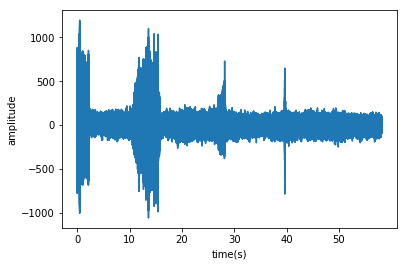

In [7]:
w = w - np.mean(w) #remove dc offset
# plt.title("New Forest bee")
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x/fs), ',')))
plt.xticks(np.arange(0,w.size,10*fs)) # set tick every ten seconds
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.plot(w)

<h2> Compute the indices every second, with total length = 50s </h2>

In [8]:
total_length = 50
freq, aci_matrix_p_batch, h_t_matrix_p_batch, cvr_matrix_p_batch, fft_matrix_p_batch = compute_acoustic_indices_batch(w, total_length, 1, fs=fs)
_, aci_matrix_p_online, h_t_matrix_p_online_approx, cvr_matrix_p_online, fft_matrix_p_online = compute_acoustic_indices_online_approx(w, total_length, 1, fs=fs)
_, _, h_t_matrix_p_online_exact, _, _ = compute_acoustic_indices_online_exact(w, total_length, 1, fs=fs)

<h2> Comparison between batch and online methods, for t = 3(s) </h2>

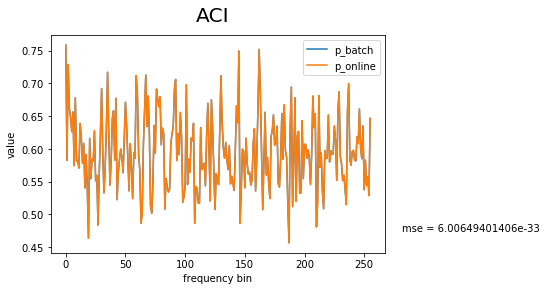

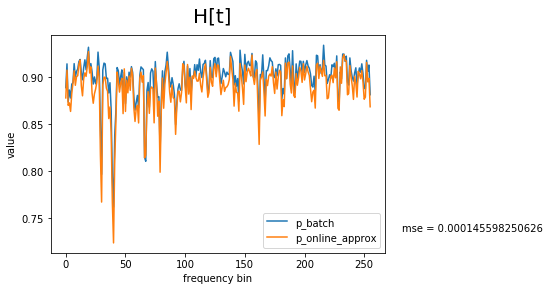

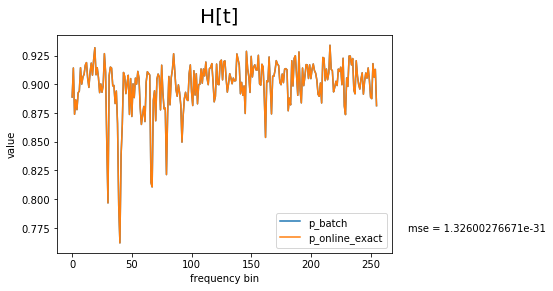

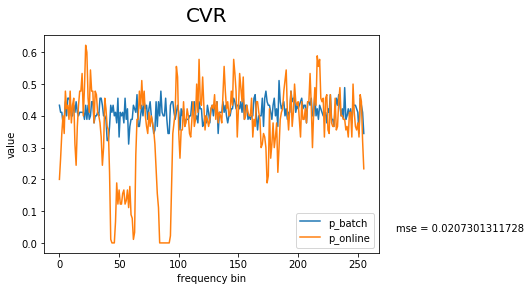

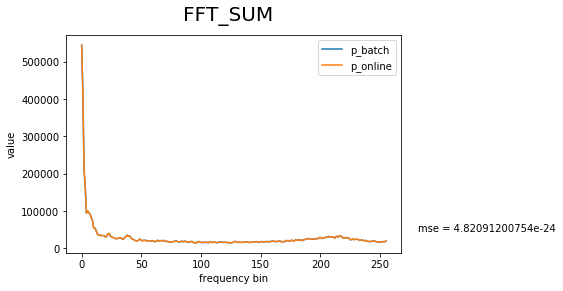

In [9]:
t = 3
plot_comparison("ACI", aci_matrix_p_batch[t], aci_matrix_p_online[t], "p_batch", "p_online")
plot_comparison("H[t]", h_t_matrix_p_batch[t], h_t_matrix_p_online_approx[t]/1.1, "p_batch", "p_online_approx") #approximation is scaled
plot_comparison("H[t]", h_t_matrix_p_batch[t], h_t_matrix_p_online_exact[t], "p_batch", "p_online_exact")
plot_comparison("CVR", cvr_matrix_p_batch[t], cvr_matrix_p_online[t], "p_batch", "p_online")
plot_comparison("FFT_SUM", fft_matrix_p_batch[t], fft_matrix_p_online[t], "p_batch", "p_online")

<h2> Repeating signal - test cvr </h2>

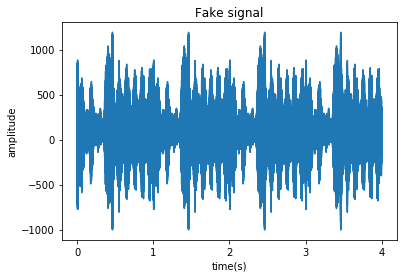

In [10]:
fakew = np.append(w[:fs],w[:fs])
fakew = np.append(fakew, fakew)
plt.title("Fake signal")
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x/fs), ',')))
plt.xticks(np.arange(0,w.size,1*fs)) # set tick every second
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.plot(fakew)

In [11]:
total_length = 4
_, _, _, cvr_matrix_fake_batch, _ = compute_acoustic_indices_batch(fakew, total_length, 1, fs=fs)
_, _, _, cvr_matrix_fake_online, _ = compute_acoustic_indices_online(fakew, total_length, 1, fs=fs)

<h2> Difference of CVR using batch and online method for t=3</h2>

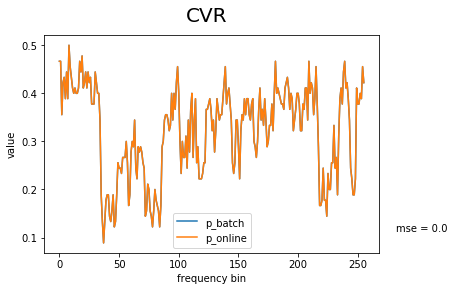

In [20]:
t = 3
plot_comparison("CVR", cvr_matrix_fake_batch[t], cvr_matrix_fake_online[t], "p_batch", "p_online")

<h2> Write the wave file as binary data to be read in C </h2>

In [14]:
f = open("NewForestBee", "ab")
for i in range(w.size):
    f.write(struct.pack('f',w[i]))
f.close()

<h2> NewForestBee_C is created by C code </h2>

In [13]:
res = []
with open("NewForestBee_C", "rb") as f:
    while True:
        b = f.read(4)
        if not b:
            break
        else:
            res.append(struct.unpack('f', b)[0])
res = np.array(res)

In [17]:
data = np.transpose(res.reshape((30,256,4)),(2,0,1))
aci_matrix_c_online = data[0]
h_t_matrix_c_online = data[1]
cvr_matrix_c_online = data[2]
fft_matrix_c_online = data[3]

<h2> Comparison between C_online and Python_online methods, for t = 0(s) (error = 0 for t>=1) </h2>

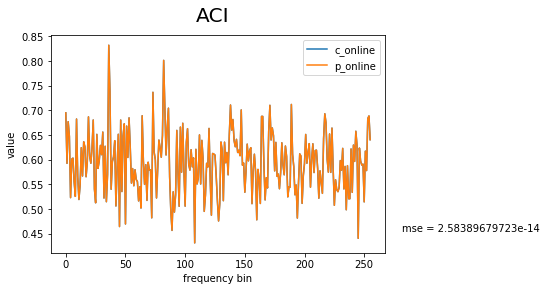

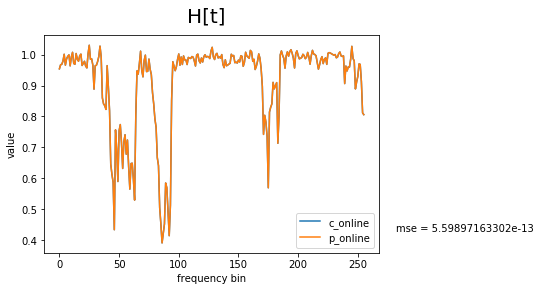

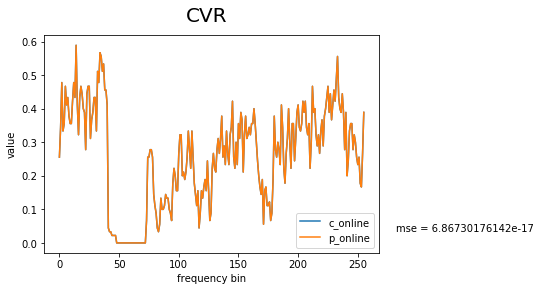

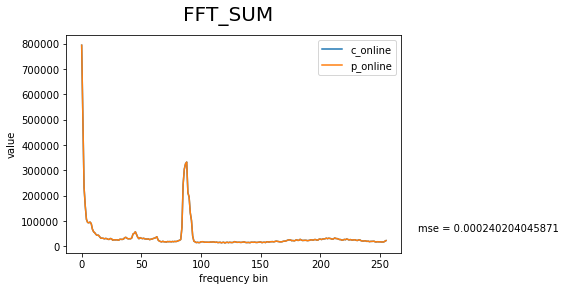

In [33]:
t = 0
plot_comparison("ACI", aci_matrix_c_online[t], aci_matrix_p_online[t], "c_online", "p_online")
plot_comparison("H[t]", h_t_matrix_c_online[t], h_t_matrix_p_online[t], "c_online", "p_online")
plot_comparison("CVR", cvr_matrix_c_online[t], cvr_matrix_p_online[t], "c_online", "p_online")
plot_comparison("FFT_SUM", fft_matrix_c_online[t], fft_matrix_p_online[t], "c_online", "p_online")

<h2> error = 0 for t=5 (for all t>=1) </h2>

In [ ]:
t = 5
plot_comparison("ACI", aci_matrix_c_online[t], aci_matrix_p_online[t], "c_online", "p_online")
plot_comparison("H[t]", h_t_matrix_c_online[t], h_t_matrix_p_online_approx[t], "c_online", "p_online")
plot_comparison("CVR", cvr_matrix_c_online[t], cvr_matrix_p_online[t], "c_online", "p_online")
plot_comparison("FFT_SUM", fft_matrix_c_online[t], fft_matrix_p_online[t], "c_online", "p_online")

In [12]:
r1 = normalize(aci_matrix_p_batch,0.4,0.7,True)
g1 = 1-normalize(h_t_matrix_p_batch,0.5,0.98,True)
b1 = normalize(cvr_matrix_p_batch,0.0,0.3,True)

r2 = normalize(aci_matrix_p_online,0.4,0.7,True)
g2 = 1-normalize(h_t_matrix_p_online_approx,0.5,0.98,True)
b2 = normalize(cvr_matrix_p_online,0.0,0.3,True)

r3 = normalize(aci_matrix_c_online,0.4,0.7,True)
g3 = 1-normalize(h_t_matrix_c_online,0.5,0.98,True)
b3 = normalize(cvr_matrix_c_online,0.0,0.3,True)

<h2> False color images </h2>

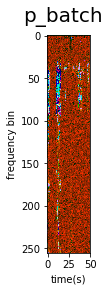

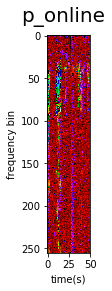

In [13]:
false_img("p_batch",r1,g1,b1)
false_img("p_online",r2,g2,b2)
false_img("c_online",r3,g3,b3)